## preapare dataset
## initialize NN (3 layers FCN)
## implement simple forward propagation
## implement the ReLU activation function
## implement softmax layer
## Implement a training loop for a simple binary classifier network

In [1]:
import numpy as np
from typing import List,Sequence

In [2]:
def init_layer(prev_layer:int, curr_layer:int) ->list[np.array]:
    weigths =  np.random.normal(loc= 0 ,scale= 1.0/curr_layer, size=(curr_layer,prev_layer))
    bias = np.random.normal(loc= 0 ,scale= 1.0/curr_layer,size=(curr_layer,1))
    return weigths,bias

In [3]:
#Implement ReLU activation function
def relu(x: float)->float:
    relu = np.maximum(0,x)

    return relu

In [4]:
#implement ReLu Prime function
def relu_prime(x: float)->float:
    rp = 1 if (x>0) else 0
    return rp

In [5]:
#Implement Sigmoid activation function
def sigmoid(x:float)->float:
    sigm = 1/(1+np.e**-x)

    return sigm

In [6]:
def sigmoid_prime(x:float)->float:
    return sigmoid(x)*(1-sigmoid(x))

In [7]:
#compute Layer output without activation function
def layer_fwd(weights,bias,x):
    out = np.dot(weights,x)+bias
    return out
    

In [8]:
class simple_nn():
    def __init__(self,layers):
        self.num_layers=len(layers) # save NN structure
        self.weights = []
        self.bias = []
        for prev_layer, curr_layer in zip(layers,layers[1:]):
            w,b= init_layer(prev_layer, curr_layer)
            self.weights.append(w)
            self.bias.append(b)

    def forward_propagation(self,input_vector):
        #forward propagation, hidden layers use ReLU activation function and ouput layer use sigmoid activation function
        #loop trough intermediate layers
        x=input_vector
        for i in range(len(self.weights)-1):
            z=layer_fwd(self.weights[i],self.bias[i],x)
            a=np.vectorize(relu)(z)
            x=a # update next layer input 

        #calculate ouput layer
        z=layer_fwd(self.weights[-1],self.bias[-1],x)
        out=np.vectorize(sigmoid)(z)

        return out
    '''
    back propagation for cuadratic cost function  " C=(1/2)*(y-out)**2 "
    return "delta_b" and "delta_w" representing the gradient propagation trough each layer
    this variables have the same dimensions than self.weights and self.bias
    '''
    def backward_propagation(self,x,y):
        #feed forward and save outputs
        layers_z=[x]
        layers_a=[x] 
        #loop trough hidden layers
        N_HL = self.num_layers-2 #number of hiden layers, ignore first and last 
        for i in range(N_HL):
            z=layer_fwd(self.weights[i],self.bias[i],x)
            a=np.vectorize(relu)(z)
            #strore output and activation for each layer
            layers_z.append(z)
            layers_a.append(a)
            x=a # update next layer input 

        #calculate ouput layer
        z=layer_fwd(self.weights[-1],self.bias[-1],x)
        out=np.vectorize(sigmoid)(z)

        layers_z.append(z)
        layers_a.append(out)

        #return layers_z,layers_a
    
        #initialize variables to store error by layer
        delta_b = [np.zeros(b.shape) for b in self.bias]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        
        #calculate last layer error and gradient
        cost_gradient = (layers_a[-1]-y) # cost function gradient 
        delta = cost_gradient*np.vectorize(sigmoid_prime)(layers_z[-1])
        delta_w[-1] = np.dot(delta,layers_a[-2].transpose())
        delta_b[-1] = delta
        #propagate error trough hiden layers
        for l in range(2, self.num_layers):
            z = layers_z[-l]
            rp = np.vectorize(relu_prime)(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) *rp
            delta_b[-l] = delta
            delta_w[-l] = np.dot(delta, layers_a[-l-1].transpose())

        cost= 0.5*(out-y)**2 #quadratic cost function
        
        return delta_b,delta_w,cost


    def update_minibatch(self,x,y,alpha):
        #update weigths and bias  for a minibatch (array of x and y pairs)
        #alpha is the learning rate

        #initialize variables to store error
        delta_b = [np.zeros(b.shape) for b in self.bias]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        cost=0
        #iterate trough pairs
        m= len(x) 
        for i in range(m):
            #calculate delta for each x,y pair 
            xi=  x[[i]].T #slice array and transpose (size = (inputs,1))
            yi = y[i]  
            dbi,dwi,cost_i= self.backward_propagation(xi,yi)
            #sum error for each pair in minibatch
            delta_b = [db+dnb for db, dnb in zip(delta_b, dbi)]
            delta_w = [dw+dnw for dw, dnw in zip(delta_w, dwi)]

            cost+=cost_i

            
        #update weights using learning rate (alpha) divided by the number of elements in minibatch
        
        self.weights = [w - (alpha/m)*nw for w,nw in zip(self.weights,delta_w)]
        self.bias    = [b - (alpha/m)*nb for b,nb in zip(self.bias,delta_b)]

        return cost/m

       # def evaluate(self,x,y):
            
            
            

## Test NN capabilities
Now we will test and train our new neural network using some artificial data generated using [scikit make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons)

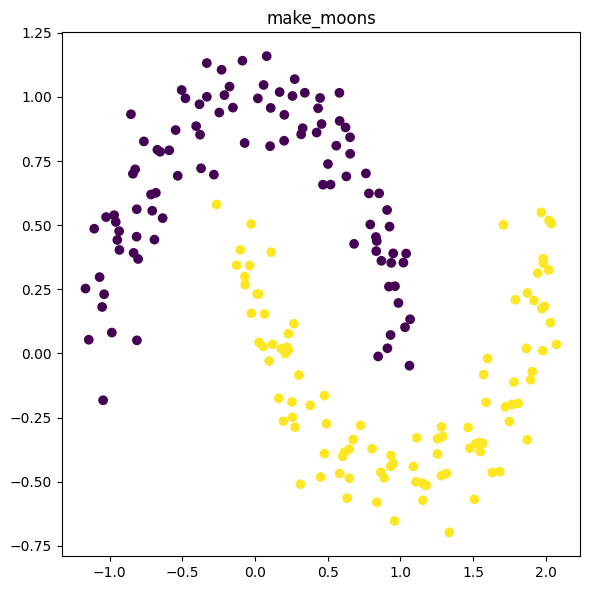

In [46]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

fig,ax  = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

X, Y = make_moons(noise=0.1, random_state=0,n_samples = 200)
ax.scatter(X[:, 0], X[:, 1], c=Y)
ax.set_title("make_moons")

plt.tight_layout()
plt.show()

In [67]:
# The code for back propagation and update minibatch is provided to you in the NN class, lets use this to train the Neural Network
def train_nn(NN:simple_nn , X_train:np.array, Y_train:np.array,batch_size, alpha : float, epochs:int):
    n_batchs = len(X_train)//batch_size # calculate number of batchs
    logs=[]
    for it in range(epochs):
        cost = 0 # restart cost for every epoch
        for i in range(n_batchs):
            #create mini batch
            xb = X_train[i*batch_size:(i+1)*batch_size]
            yb = Y_train[i*batch_size:(i+1)*batch_size] 
            # update weigths for the minibatch
            batch_cost = NN.update_minibatch(x=xb,y=yb,alpha=alpha) 
            cost += batch_cost.item()
        #calculate training metrics
        y_pred =1*(NN.forward_propagation(X_train.T)>0.5)
        train_accuracy = np.sum(y_pred==Y_train) /len(Y_train)
        logs.append([cost,train_accuracy]) #save all costs

        #print every 10 epochs
        if(it%20 == 0): 
            print ("epoch {} finished, train_cost = {:0.3f}, train_accuracy = {:0.3f} ".format(it,cost,train_accuracy))

    return logs

In [68]:
nn1 = simple_nn([2,6,1])
#split the dataset in test and train 70% train, 30% test

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
logs = train_nn(nn1,X_train,y_train,batch_size=12,alpha=0.01,epochs=500)

epoch 0 finished, train_cost = 2.051, train_accuracy = 0.457 
epoch 20 finished, train_cost = 1.809, train_accuracy = 0.457 
epoch 40 finished, train_cost = 1.668, train_accuracy = 0.457 
epoch 60 finished, train_cost = 1.533, train_accuracy = 0.457 
epoch 80 finished, train_cost = 1.396, train_accuracy = 0.457 
epoch 100 finished, train_cost = 1.260, train_accuracy = 0.457 
epoch 120 finished, train_cost = 1.128, train_accuracy = 0.629 
epoch 140 finished, train_cost = 1.007, train_accuracy = 0.821 
epoch 160 finished, train_cost = 0.909, train_accuracy = 0.843 
epoch 180 finished, train_cost = 0.831, train_accuracy = 0.829 
epoch 200 finished, train_cost = 0.771, train_accuracy = 0.850 
epoch 220 finished, train_cost = 0.725, train_accuracy = 0.857 
epoch 240 finished, train_cost = 0.688, train_accuracy = 0.871 
epoch 260 finished, train_cost = 0.659, train_accuracy = 0.871 
epoch 280 finished, train_cost = 0.635, train_accuracy = 0.879 
epoch 300 finished, train_cost = 0.616, train_

In [45]:
# test NN accuracy, 0.5 is a treshold to decide if the output belog to one class or the other
#neural network will output a probability p that the input belongs to class 1
y_pred =1*(nn1.forward_propagation(X_test.T)>0.5)
test_accuracy = np.sum(y_pred==y_test) / len(y_test)
print ("test accuracy = {:0.3f} ".format(test_accuracy))

test accuracy = 0.833 


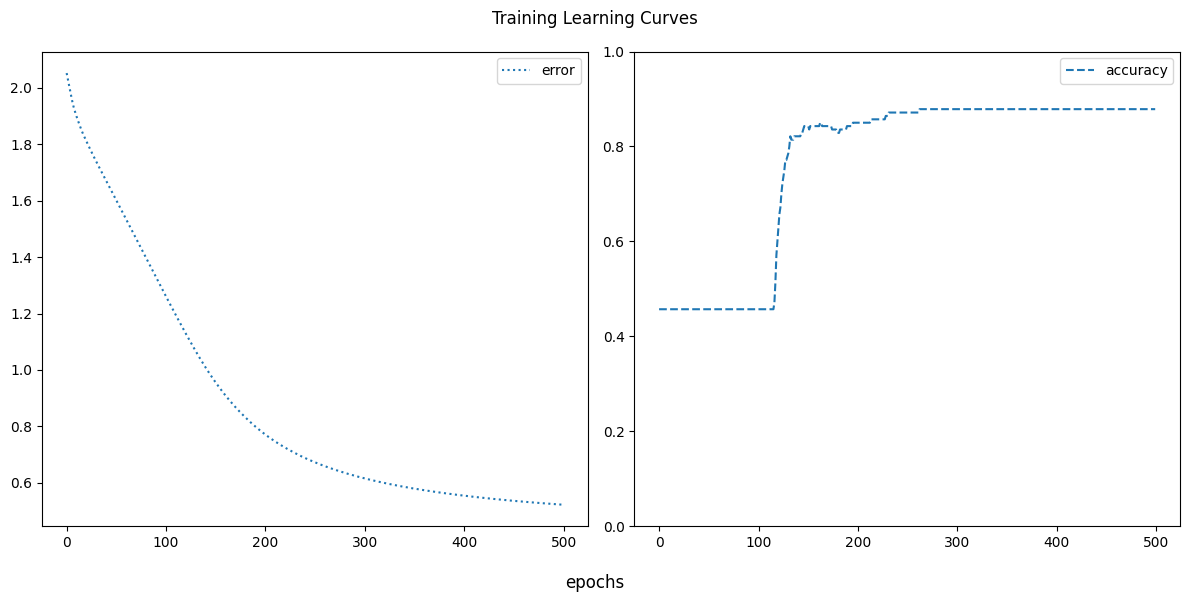

In [71]:
## plot Neural Network Learning curves
fig,(ax1,ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
data = np.asarray(logs)

ax1.plot(data[:,0],linestyle = 'dotted',label = 'error')
ax1.legend()

ax2.plot(data[:,1],linestyle = 'dashed', label ='accuracy')
ax2.set_ylim(0,1)
ax2.legend()

fig.suptitle("Training Learning Curves")
fig.supxlabel("epochs")
plt.tight_layout()
plt.show()